In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Feature Names
feature_names = ['amino_acids', 'cleavage']

# LOAD DATA
train_df = pd.read_csv('hiv1_1.csv', names=feature_names)
test_df = pd.read_csv('hiv1_2.csv', names=feature_names)
print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)
train_df.head()

Train shape: (1625, 2)
Test shape: (746, 2)


,amino_acids,cleavage
0,SLNLRETN,1
1,AECFRIFD,1
2,HLVEALYL,1
3,TQIMFETF,1
4,AEELAEIF,1


In [3]:
'''ONE HOT ENCODE AMINO ACIDS'''
amino_acids = ['G', 'P', 'A', 'V', 'L', 'I', 'M', 'C', 'F', 'Y', 'W', 'H' ,'K',
               'R', 'Q', 'N', 'E', 'D', 'S', 'T']

# Create aa Columns by position
for amino_acid in amino_acids:
    for i in range(8):
        amino_pos = amino_acid + str(i)
        train_df[amino_pos] = 0
        test_df[amino_pos] = 0

# Combine DataFrames Momentarily
combined_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
    
# One-Hot Encodings of Amino Acids
for i, protein in enumerate(combined_df['amino_acids'].values):
    # Iterate through protein sequence
    for j, aa in enumerate(protein):
        amino_pos = aa + str(j)
        combined_df.loc[i, amino_pos] = 1

In [4]:
combined_df.head()

,amino_acids,cleavage,G0,G1,G2,G3,G4,G5,G6,G7,...,S6,S7,T0,T1,T2,T3,T4,T5,T6,T7
0,SLNLRETN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,AECFRIFD,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HLVEALYL,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TQIMFETF,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,AEELAEIF,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Drop amino_acids string
combined_df = combined_df.drop(columns='amino_acids')
combined_df.shape

(2371, 161)

In [90]:
data_x = combined_df.iloc[:, 1:]
data_y = combined_df.iloc[:, 0]

In [91]:
from sklearn.model_selection import train_test_split

# Random Train Test Split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,
                                                    test_size=0.30,
                                                    shuffle=True,
                                                    random_state=42)

# Prevents issues with CV
train_x.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

In [92]:
print(train_y.value_counts())
print(test_y.value_counts())

-1    1125
 1     534
Name: cleavage, dtype: int64
-1    469
 1    243
Name: cleavage, dtype: int64


### Cross Validation


#### LEARNING CURVES

In [177]:
'''LEARNING CURVE!!!'''
'''Stratified Shuffle K-fold CV, AT DIFFERENT SAMPLE SIZES'''
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# For storing statistics for future plots
fold_train_scores = []
fold_val_scores = []
number_samples_list = []


'''MODEL BUILD HERE'''
# DecisionTreeClassifier(criterion='entropy', max_depth=9)
# AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5), n_estimators=25)
# MLPClassifier(hidden_layer_sizes=(160, 160), max_iter=35, learning_rate_init=0.001)
# SVC(kernel='linear')
# KNeighborsClassifier(n_neighbors=1)
model = SVC(kernel='linear')

for i in [2, 3, 4, 5, 7, 9, 11, 13, 50, 100, 533]:
    '''
    Loop through a set of folds of CV
    Collect success metrics for each CV run
    Plot # of folds/# of samples vs success metric
    '''
    
    # Get splits of CV
    folds = i
    number_samples = int(train_x.shape[0] - (train_x.shape[0]/folds))
    sss = StratifiedKFold(folds)

    # Store Scoring Metric
    train_scores = []
    val_scores = []

    print('# of samples:', number_samples)
    for train_index, val_index in sss.split(train_x, train_y):

        # Train and validation sets
        partial_train_x, val_x = train_x.iloc[train_index, :], train_x.iloc[val_index, :]
        partial_train_y, val_y = train_y[train_index], train_y[val_index]

        # Build and Train Model
        clf = model
        clf.fit(partial_train_x, partial_train_y)

        # Collect success metrics
        train_score = clf.score(partial_train_x, partial_train_y)
        train_scores.append(train_score)

        val_score = clf.score(val_x, val_y)
        val_scores.append(val_score)


    # Get average scores from CV
    avg_train = np.average(train_scores)
    avg_val = np.average(val_scores)

    # Append to final score lists
    fold_train_scores.append(avg_train)
    fold_val_scores.append(avg_val)
    number_samples_list.append(number_samples)
    
# Reverse CV where training is the fold left out and test is all the other folds
for i in [2, 3, 4, 5, 7, 9, 11, 13, 50, 100, 533]:
    '''
    Loop through a set of folds of CV
    Collect success metrics for each CV run
    Plot # of folds/# of samples vs success metric
    '''
    
    # Get splits of CV
    folds = i
    number_samples = int(train_x.shape[0]/folds)
    sss = StratifiedKFold(folds)

    # Store Scoring Metric
    train_scores = []
    val_scores = []

    print('# of samples:', number_samples)
    for train_index, val_index in sss.split(train_x, train_y):

        # Train and validation sets
        partial_train_x, val_x = train_x.iloc[val_index, :], train_x.iloc[train_index, :]
        partial_train_y, val_y = train_y[val_index], train_y[train_index]

        # Build and Train Model
        clf = model
        clf.fit(partial_train_x, partial_train_y)

        # Collect success metrics
        train_score = clf.score(partial_train_x, partial_train_y)
        train_scores.append(train_score)

        val_score = clf.score(val_x, val_y)
        val_scores.append(val_score)


    # Get average scores from CV
    avg_train = np.average(train_scores)
    avg_val = np.average(val_scores)

    # Append to final score lists
    fold_train_scores.append(avg_train)
    fold_val_scores.append(avg_val)
    number_samples_list.append(number_samples)

# of samples: 829
# of samples: 1106
# of samples: 1244
# of samples: 1327
# of samples: 1422
# of samples: 1474
# of samples: 1508
# of samples: 1531
# of samples: 1625
# of samples: 1642
# of samples: 1655
# of samples: 829
# of samples: 553
# of samples: 414
# of samples: 331
# of samples: 237
# of samples: 184
# of samples: 150
# of samples: 127
# of samples: 33
# of samples: 16
# of samples: 3


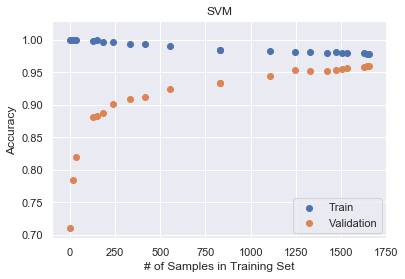

In [178]:
'''# of Samples vs Accuracy Rate'''
# Change title, xlabel, ylabel appropriately
xlabel = '# of Samples in Training Set'
ylabel = 'Accuracy'
title = 'SVM'
dataset = 'HIV1'

plt.scatter(x=number_samples_list, y=fold_train_scores, label='Train')
plt.scatter(x=number_samples_list, y=fold_val_scores, label='Validation')

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.legend()

# Saving plots
plt.savefig("plots/" + dataset + '_' + title + '_' + xlabel + ".png")

plt.show()

#### MODEL COMPLEXITY

In [165]:
'''MODEL COMPLEXITY CURVE'''
'''Stratified Shuffle K-fold CV'''
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# For storing statistics for future plots
hyperparameter_train_scores = []
hyperparameter_val_scores = []
hyperparameter_list = []

# range(1, 30, 1)
# range(1, 100, 1)
# range(10, 300, 25)
# [0.001, 0.005, 0.01, 0.025, 0.05, 0.10, 0.20]
# ['linear', 'poly', 'rbf', 'sigmoid']
# [0.05, 0.10, 0.25, 0.50, 1.0, 1.5, 2.0, 3.0]
# range(1, 10, 1)

for i in ['linear', 'poly', 'rbf', 'sigmoid']:                        
    '''
    Loop through a range of values for a particular hyperparameter
    Collect success metric for each discrete hyperparameter value
        - Must determine at what number of CV folds to choose
    Plot the hyperparameters vs the success metric
    '''
    print(i)
    
    
    '''MODEL BUILD HERE'''
    # DecisionTreeClassifier(criterion='entropy', max_depth=i)
    # AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5), n_estimators=i)
    # MLPClassifier(hidden_layer_sizes=(160, 160), max_iter=60, learning_rate_init=i)
    # SVC(kernel=i)
    # KNeighborsClassifier(n_neighbors=i)
    clf = SVC(kernel=i)
    
    # Get splits of CV
    folds = 2                                   # CHANGE # of FOLDS HERE
    sss = StratifiedKFold(folds)

    # Store Scoring Metric
    train_scores = []
    val_scores = []

    for train_index, val_index in sss.split(train_x, train_y):

        # Train and validation sets
        partial_train_x, val_x = train_x.iloc[train_index, :], train_x.iloc[val_index, :]
        partial_train_y, val_y = train_y[train_index], train_y[val_index]

        # Build and Train Model          
        clf.fit(partial_train_x, partial_train_y)

        # Collect success metrics
        train_score = clf.score(partial_train_x, partial_train_y)
        train_scores.append(train_score)

        val_score = clf.score(val_x, val_y)
        val_scores.append(val_score)


    # Get average scores from CV
    avg_train = np.average(train_scores)
    avg_val = np.average(val_scores)

    # Append to final score lists
    hyperparameter_train_scores.append(avg_train)
    hyperparameter_val_scores.append(avg_val)
    hyperparameter_list.append(i)

linear
poly
rbf
sigmoid


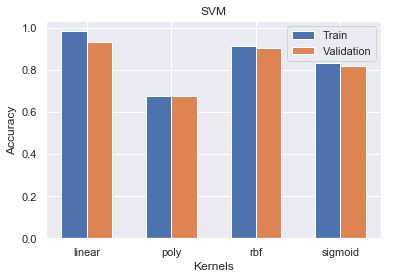

In [176]:
'''hyperparameter vs Accuracy Rate'''
# Change title, xlabel, ylabel appropriately
xlabel = 'Kernels'
ylabel = 'Accuracy'
title = 'SVM'
dataset = 'HIV1'

sns.set()

# ONLY FOR SVM KERNEL COMPARISON PLOTS
plt.bar(x=hyperparameter_list, height=hyperparameter_train_scores,
        width=-0.3, align='edge', label='Train')
plt.bar(x=hyperparameter_list, height=hyperparameter_val_scores,
        width=0.3, align='edge', label='Validation')

# plt.scatter(x=hyperparameter_list, y=hyperparameter_train_scores, label='Train')
# plt.scatter(x=hyperparameter_list, y=hyperparameter_val_scores, label='Validation')

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)

plt.legend()

# Saving plots
plt.savefig("plots/" + dataset + '_' + title + '_' + xlabel + ".png")

plt.show()

#### TIME COMPLEXITY

In [225]:
'''TIME COMPLEXITY CURVE'''
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time

# For storing statistics for future plots
iteration_count = []
time_elapsed = []

for i in range(10, 300, 10):                        
    '''
    Loop through a range of values for a iterations
    Collect time it takes per iteration
    Plot the iteration vs time
    '''
    print(i)
    iteration_count.append(i)
    
    '''MODEL BUILD HERE'''
    # AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=i)
    # MLPClassifier(hidden_layer_sizes=(160, 160), learning_rate_init=0.001, max_iter=i)
    # SVC(kernel='linear', max_iter=i)
    clf = MLPClassifier(hidden_layer_sizes=(160, 160), learning_rate_init=0.001, max_iter=i)
    
    # START TIME
    start = time.time()
    
    # Train on full dataset
    clf.fit(train_x, train_y)
    
    # END TIME
    end = time.time()
    time_elapsed.append(end - start)

10


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


20


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


30


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


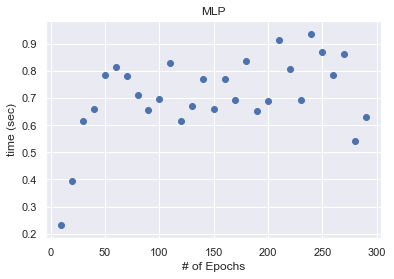

In [226]:
'''NUMBER OF ITERATIONS VS TIME'''
# Change title, xlabel, ylabel appropriately
xlabel = '# of Epochs'
ylabel = 'time (sec)'
title = 'MLP'
dataset = 'HIV1'

sns.set()

plt.scatter(x=iteration_count, y=time_elapsed)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)

# Saving plots
plt.savefig("plots/" + dataset + '_' + title + '_' + xlabel + "_time.png")

plt.show()

In [223]:
'''TIME COMPLEXITY CURVES WITH VARYING SAMPLE SIZE'''
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time

# For storing statistics for future plots
train_sample_size = []
val_sample_size = []
train_time_elapsed = []
val_time_elapsed = []

for i in [i * 0.1 for i in range(1, 10)]:                        
    '''
    Loop through a range of sample sizes
    Calculate start and end times for test and training sets
    Plot the sample size vs time
    '''
    print(i)
    train_size = int(len(train_x) * i)
    train_sample_size.append(train_size)
    
    # Create train/validation sets
    partial_train_x = train_x[:train_size]
    partial_train_y = train_y[:train_size]
    val_x = train_x[train_size:]
    val_y = train_y[train_size:]
    
    val_sample_size.append(len(val_y))
    
    '''MODEL BUILD HERE'''
    # DecisionTreeClassifier(criterion='entropy', max_depth=9)
    # AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5), n_estimators=25)
    # MLPClassifier(hidden_layer_sizes=(160, 160), max_iter=35, learning_rate_init=0.001)
    # SVC(kernel='linear')
    # KNeighborsClassifier(n_neighbors=1)
    clf = KNeighborsClassifier(n_neighbors=1)
    
    # TRAINING
    # START TIME
    start_train = time.time()
    
    # Train on full dataset
    clf.fit(train_x, train_y)
    
    # END TIME
    end_train = time.time()
    train_time_elapsed.append(end_train - start_train)
    
    # VALIDATION
    # START TIME
    start_val = time.time()
    
    # Train on full dataset
    clf.predict(val_x)
    
    # END TIME
    end_val = time.time()
    val_time_elapsed.append(end_val - start_val)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


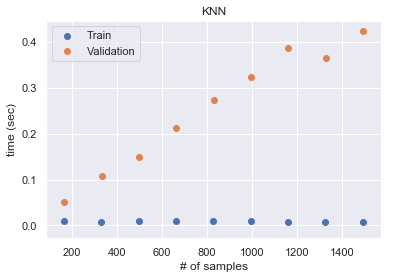

In [224]:
'''SAMPLE SIZE VS TIME'''
# Change title, xlabel, ylabel appropriately
xlabel = '# of samples'
ylabel = 'time (sec)'
title = 'KNN'
dataset = 'HIV1'

sns.set()

plt.scatter(x=train_sample_size, y=train_time_elapsed, label='Train')
plt.scatter(x=val_sample_size, y=val_time_elapsed, label='Validation')

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.legend()

# Saving plots
plt.savefig("plots/" + dataset + '_' + title + '_' + xlabel + "_time.png")

plt.show()

## FINAL MODEL BUILDS

In [181]:
# Scorers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

#### Decision Tree

In [204]:
from sklearn.tree import DecisionTreeClassifier

# Build Architecture
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=9)

print('2-fold CV Accuracy:', np.mean(cross_val_score(clf, train_x, train_y, cv=2)))

clf.fit(train_x, train_y)

pred = clf.predict(test_x)

print('Test Accuracy:', clf.score(test_x, test_y))

confusion_matrix(test_y, pred)

2-fold CV Accuracy: 0.9047633234990626
Test Accuracy: 0.9185393258426966


array([[444,  25],
       [ 33, 210]])

#### AdaBoost

In [190]:
from sklearn.ensemble import AdaBoostClassifier

# Build Architecture
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=5), 
                         n_estimators=25)

print('2-fold CV Accuracy:', np.mean(cross_val_score(clf, train_x, train_y, cv=2)))

clf.fit(train_x, train_y)

pred = clf.predict(test_x)

print('Test Accuracy:', clf.score(test_x, test_y))

confusion_matrix(test_y, pred)

2-fold CV Accuracy: 0.929476652084817
Test Accuracy: 0.9648876404494382


array([[451,  18],
       [  7, 236]])

#### Multi-Layer Perceptron (MLP)

In [191]:
from sklearn.neural_network import MLPClassifier

# Build Architecture
clf = MLPClassifier(hidden_layer_sizes=(160, 160), max_iter=35, 
                    learning_rate_init=0.001)

print('2-fold CV Accuracy:', np.mean(cross_val_score(clf, train_x, train_y, cv=2)))

clf.fit(train_x, train_y)

pred = clf.predict(test_x)

print('Test Accuracy:', clf.score(test_x, test_y))

confusion_matrix(test_y, pred)

/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


2-fold CV Accuracy: 0.9457438923365356
Test Accuracy: 0.976123595505618


/Users/jdemeo/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[458,  11],
       [  6, 237]])

#### SVM
- Kernel: rbf, linear, poly, sigmoid

In [192]:
from sklearn.svm import SVC

# Build Architecture
clf = SVC(kernel='linear')

print('2-fold CV Accuracy:', np.mean(cross_val_score(clf, train_x, train_y, cv=2)))

clf.fit(train_x, train_y)

pred = clf.predict(test_x)

print('Test Accuracy:', clf.score(test_x, test_y))

confusion_matrix(test_y, pred)

2-fold CV Accuracy: 0.9336884328629355
Test Accuracy: 0.9606741573033708


array([[451,  18],
       [ 10, 233]])

#### KNN

In [198]:
from sklearn.neighbors import KNeighborsClassifier

# Build Architecture
clf = KNeighborsClassifier(n_neighbors=1)

print('2-fold CV Accuracy:', np.mean(cross_val_score(clf, train_x, train_y, cv=2)))

clf.fit(train_x, train_y)

pred = clf.predict(test_x)

print('Test Accuracy:', clf.score(test_x, test_y))

confusion_matrix(test_y, pred)

2-fold CV Accuracy: 0.872209222898833
Test Accuracy: 0.9087078651685393


array([[413,  56],
       [  9, 234]])